In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dir_path = '/content/drive/MyDrive/DataScience/SIGNATE/SMBC GREEN×DATA Challenge/データ/'
df_train = pd.read_csv(dir_path + 'train.csv')
df_test = pd.read_csv(dir_path + 'test.csv')

In [3]:
df_train.head()

,Unnamed: 0,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,...,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
0,0,2015-06-29,14,OnCurb,1,NaN,NaN,Damage,Volunteer,NaN,...,QN45,Douglas Manor-Douglaston-Little Neck,4,4152901,Queens,Little Neck,411,11,25,23
1,1,2016-09-21,5,OnCurb,1,3or4,Helpful,NoDamage,Volunteer,NaN,...,BX05,Bedford Park-Fordham North,2,2039901,Bronx,Bronx,207,33,78,15
2,2,2015-09-13,26,OnCurb,2,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,...,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,5,5017011,Staten Island,Staten Island,503,24,62,51
3,3,2016-05-09,15,OnCurb,0,NaN,NaN,Damage,NYC Parks Staff,NaN,...,SI11,Charleston-Richmond Valley-Tottenville,5,5024401,Staten Island,Staten Island,503,24,62,51
4,4,2016-06-24,23,OnCurb,1,NaN,NaN,NoDamage,Volunteer,Stones,...,MN03,Central Harlem North-Polo Grounds,1,1022102,Manhattan,New York,110,30,70,9


In [4]:
df_test.head()

,Unnamed: 0,created_at,tree_dbh,curb_loc,steward,guards,sidewalk,user_type,problems,spc_common,...,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
0,19984,2015-09-08,15,OnCurb,NaN,NaN,Damage,NYC Parks Staff,NaN,Callery pear,...,BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,3,3062000,Brooklyn,Brooklyn,315,22,45,48
1,19985,2015-10-15,5,OnCurb,1or2,NaN,NoDamage,Volunteer,NaN,cherry,...,BX62,Woodlawn-Wakefield,2,2045101,Bronx,Bronx,212,34,81,11
2,19986,2016-08-03,4,OnCurb,NaN,Unsure,NoDamage,Volunteer,NaN,littleleaf linden,...,QN60,Kew Gardens,4,4013800,Queens,Kew Gardens,409,14,27,29
3,19987,2015-08-06,7,OnCurb,NaN,NaN,NoDamage,TreesCount Staff,NaN,dawn redwood,...,BK09,Brooklyn Heights-Cobble Hill,3,3000301,Brooklyn,Brooklyn,302,26,52,33
4,19988,2015-10-21,6,OnCurb,1or2,Helpful,NoDamage,TreesCount Staff,Stones,purple-leaf plum,...,BK75,Bedford,3,3025100,Brooklyn,Brooklyn,303,25,56,36


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19984 entries, 0 to 19983
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  19984 non-null  int64 
 1   created_at  19984 non-null  object
 2   tree_dbh    19984 non-null  int64 
 3   curb_loc    19984 non-null  object
 4   health      19984 non-null  int64 
 5   steward     5101 non-null   object
 6   guards      5041 non-null   object
 7   sidewalk    19984 non-null  object
 8   user_type   19984 non-null  object
 9   problems    7741 non-null   object
 10  spc_common  19984 non-null  object
 11  spc_latin   19984 non-null  object
 12  nta         19984 non-null  object
 13  nta_name    19984 non-null  object
 14  borocode    19984 non-null  int64 
 15  boro_ct     19984 non-null  int64 
 16  boroname    19984 non-null  object
 17  zip_city    19984 non-null  object
 18  cb_num      19984 non-null  int64 
 19  st_senate   19984 non-null  int64 
 20  st_ass

In [6]:
spc_common = df_train['spc_common'].value_counts()
spc = spc_common.index
nta_name = df_train['nta'].value_counts()
nta = nta_name.index
zip_city = df_train['zip_city'].value_counts()
city = zip_city.index

In [7]:
df_train_ = df_train.set_index('Unnamed: 0')
df_train_['created_at'] = pd.to_datetime(df_train_['created_at'])
df_train_['year'] = df_train_['created_at'].dt.year
df_train_['month'] = df_train_['created_at'].dt.month
df_train_['day'] = df_train_['created_at'].dt.day
df_train_['curb_loc'] = df_train_['curb_loc'].replace({'OnCurb':1,'OffsetFromCurb':0})
df_train_['steward'] = df_train_['steward'].replace({'1or2':0,'3or4':1,'4orMore':2})
df_train_['guards'] = df_train_['guards'].replace({'Helpful':0,'Harmful':1,'Unsure':2})
df_train_['sidewalk'] = df_train_['sidewalk'].replace({'Damage':0,'NoDamage':1})
df_train_['user_type'] = df_train_['user_type'].replace({'Volunteer':0,'NYC Parks Staff':1,
                                                         'TreesCount Staff':2})
for i in range(len(spc)):
    df_train_['spc_common'] = df_train_['spc_common'].replace(spc[i],i)

for i in range(len(nta)):
    df_train_['nta'] = df_train_['nta'].replace(nta[i],i)

for i in range(len(city)):
    df_train_['zip_city'] = df_train_['zip_city'].replace(city[i],i)

df_train_ = df_train_.drop({'steward','guards','created_at','spc_latin','nta_name','boroname','problems',
                            'year',
                            # 'month',
                            # 'day',
                            # 'borocode',
                            },axis=1)
# df_train_ = df_train_.dropna()
df_train_.head(3)

,tree_dbh,curb_loc,health,sidewalk,user_type,spc_common,nta,borocode,boro_ct,zip_city,cb_num,st_senate,st_assem,cncldist,month,day
Unnamed: 0,,,,,,,,,,,,,,,,
0,14,1,1,0,0,5,13,4,4152901,13,411,11,25,23,6,29
1,5,1,1,1,0,22,158,2,2039901,2,207,33,78,15,9,21
2,26,1,2,1,0,5,5,5,5017011,1,503,24,62,51,9,13


In [8]:
df_train_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19984 entries, 0 to 19983
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   tree_dbh    19984 non-null  int64
 1   curb_loc    19984 non-null  int64
 2   health      19984 non-null  int64
 3   sidewalk    19984 non-null  int64
 4   user_type   19984 non-null  int64
 5   spc_common  19984 non-null  int64
 6   nta         19984 non-null  int64
 7   borocode    19984 non-null  int64
 8   boro_ct     19984 non-null  int64
 9   zip_city    19984 non-null  int64
 10  cb_num      19984 non-null  int64
 11  st_senate   19984 non-null  int64
 12  st_assem    19984 non-null  int64
 13  cncldist    19984 non-null  int64
 14  month       19984 non-null  int64
 15  day         19984 non-null  int64
dtypes: int64(16)
memory usage: 2.6 MB


In [9]:
df_test_ = df_test.set_index('Unnamed: 0')
df_test_['created_at'] = pd.to_datetime(df_test_['created_at'])
df_test_['year'] = df_test_['created_at'].dt.year
df_test_['month'] = df_test_['created_at'].dt.month
df_test_['day'] = df_test_['created_at'].dt.day
df_test_['curb_loc'] = df_test_['curb_loc'].replace({'OnCurb':1,'OffsetFromCurb':0})
df_test_['steward'] = df_test_['steward'].replace({'1or2':0,'3or4':1,'4orMore':2})
df_test_['guards'] = df_test_['guards'].replace({'Helpful':0,'Harmful':1,'Unsure':2})
df_test_['sidewalk'] = df_test_['sidewalk'].replace({'Damage':0,'NoDamage':1})
df_test_['user_type'] = df_test_['user_type'].replace({'Volunteer':0,'NYC Parks Staff':1,
                                                         'TreesCount Staff':2})
for i in range(len(spc)):
    df_test_['spc_common'] = df_test_['spc_common'].replace(spc[i],i)

for i in range(len(nta)):
    df_test_['nta'] = df_test_['nta'].replace(nta[i],i)

for i in range(len(city)):
    df_test_['zip_city'] = df_test_['zip_city'].replace(city[i],i)

df_test_ = df_test_.drop({'steward','guards','created_at','spc_latin','nta_name','boroname','problems',
                          'year',
                        #   'month',
                        #   'day',
                        #   'borocode',
                          },axis=1)
df_test_.head(3)

,tree_dbh,curb_loc,sidewalk,user_type,spc_common,nta,borocode,boro_ct,zip_city,cb_num,st_senate,st_assem,cncldist,month,day
Unnamed: 0,,,,,,,,,,,,,,,
19984,15,1,0,1,7,49,3,3062000,0,315,22,45,48,9,8
19985,5,1,1,0,2,84,2,2045101,2,212,34,81,11,10,15
19986,4,1,1,0,4,85,4,4013800,33,409,14,27,29,8,3


In [10]:
x = df_train_.drop('health',axis=1)
x.head()

,tree_dbh,curb_loc,sidewalk,user_type,spc_common,nta,borocode,boro_ct,zip_city,cb_num,st_senate,st_assem,cncldist,month,day
Unnamed: 0,,,,,,,,,,,,,,,
0,14,1,0,0,5,13,4,4152901,13,411,11,25,23,6,29
1,5,1,1,0,22,158,2,2039901,2,207,33,78,15,9,21
2,26,1,1,0,5,5,5,5017011,1,503,24,62,51,9,13
3,15,1,0,1,8,1,5,5024401,1,503,24,62,51,5,9
4,23,1,1,0,0,101,1,1022102,3,110,30,70,9,6,24


In [11]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x = scaler.fit_transform(x)

In [12]:
y = df_train_['health']
y

Unnamed: 0
0        1
1        1
2        2
3        0
4        1
        ..
19979    2
19980    1
19981    0
19982    1
19983    1
Name: health, Length: 19984, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, t_train, t_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [14]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0, k_neighbors=10)
x_train_sampling, t_train_sampling = smote.fit_resample(x_train, t_train)

<Axes: xlabel='health', ylabel='count'>

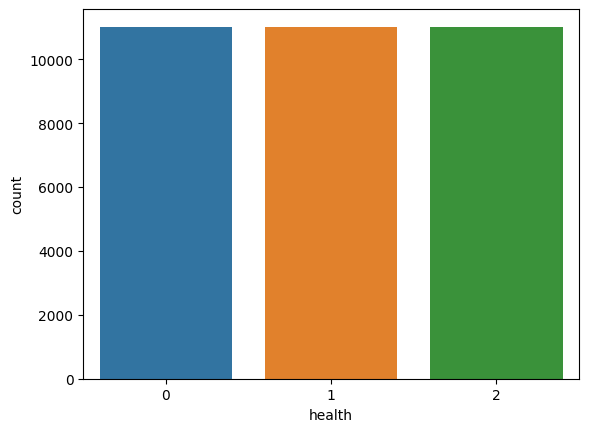

In [15]:
import seaborn as sns
sns.countplot(x=t_train_sampling)

In [16]:
lgb_train = lgb.Dataset(x_train_sampling, t_train_sampling, free_raw_data=False)
lgb_test = lgb.Dataset(x_test, t_test)

In [17]:
params = {
    'objective':'multiclass',
    'seed':0,
    'num_iterations':680,
    'learning_rate':0.02,
    'num_class':3,
    # 'verbose':1,
    # 'max_depth':-1,
    'metrics':'multi_logloss',
    'num_leaves':31,
    # 'early_stopping_round':0,
    # 'lambda_l1':0,
    # 'lambda_l2':0,
    # 'min_gain_to_split':0,
    # 'bagging_freq':2,
    # 'reg_alpha':0,
    # 'reg_lambda':0,
    # 'bagging_fraction':1.0,
    # 'feature_fraction':1.0,
    # 'min_data_in_leaf':20,
    # 'colsample_bytree':1,
    # 'subsample':1,
    # 'max_bin':255,
    # 'weight_column':,
    # 'subsample_freq':100,
    # 'min_child_samples':20,
}

model = lgb.train(
    params,
    lgb_train,
    valid_sets = lgb_test,
    num_boost_round = 100,
    # categorical_feature = cat_list,
)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 33066, number of used features: 15
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


In [18]:
prepre = model.predict(x_train, num_iteration=model.best_iteration)
prepre = np.argmax(prepre, axis=1)

pre = model.predict(x_test, num_iteration=model.best_iteration)
pre = np.argmax(pre, axis=1)
pre[:100]

array([2, 1, 1, 2, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 2, 0, 1, 1, 2, 0, 2,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1])

In [25]:
from sklearn.metrics import f1_score
print(f1_score(t_train, prepre, average='macro'))
print(f1_score(t_test, pre, average='macro'))

0.5142264874421939
0.34710542453494936


In [20]:
pd.crosstab(t_test,pre)

col_0,0,1,2
health,,,
0,274,711,88
1,1017,3373,339
2,33,142,19


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

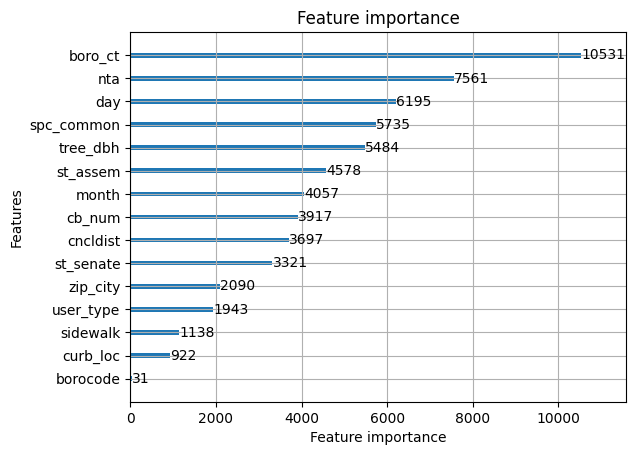

In [21]:
lgb.plot_importance(model)

In [22]:
prediction = model.predict(df_test_, num_iteration=model.best_iteration)
prediction = np.argmax(prediction, axis=1)
prediction

array([0, 1, 1, ..., 1, 1, 1])

In [23]:
submission = df_test.copy()
submission['health'] = prediction
submission = submission[['Unnamed: 0','health']]
submission['health'] = submission['health'].astype(int)
submission

,Unnamed: 0,health
0,19984,0
1,19985,1
2,19986,1
3,19987,1
4,19988,1
...,...,...
19697,39964,1
19698,39965,0
19699,39966,1
19700,39967,1


In [24]:
submission.to_csv('submission_lgbm_8.csv',index=False, header=False)